In [2]:
#  IMPORTS

import pandas as pd
from metrics.energy_estimation import MetricsEE
from metrics.event_detection import MetricsED
from metrics.hybrid_metrics import HybridMetrics

In [3]:
# Aux Function to Load data

import glob

def load_predictions(folder):
    y_true = pd.read_csv('{}/gt.csv'.format(folder), index_col='datetime_utc', parse_dates=True)
    
    dict_pred = {}
    temp_files = glob.glob('{}/Model *.csv'.format(folder))
    for file in temp_files:
        model_name = file.split('\\')[-1].split('.')[0]
        prediction_file = pd.read_csv(file, index_col='datetime_utc', parse_dates=True)
        prediction_file.loc[prediction_file['PV'] < 0] = 0
        dict_pred[model_name] = prediction_file
        
    return y_true, dict_pred


def load_upac(folder):
    # folder should be something like 'results/nn/upac08'
    
    train_gt, train_pred = load_predictions('{}/train'.format(folder))
    val_gt, val_pred = load_predictions('{}/val'.format(folder))
    test_gt, test_pred = load_predictions('{}/test'.format(folder))
    
    gt = {'train': train_gt,
          'val': val_gt,
          'test': test_gt}
    
    pred = {'train': train_pred,
            'val': val_pred,
            'test': test_pred}
    
    return gt, pred
    

def load_algorithm(folder):
    # Create a couple dictionaries for storing the several instances
    gt_dict = {}
    pred_dict = {}
    
    folders = glob.glob(folder)
    for i in np.arange(len(folders)):
        upac_name = folders[i].split('\\')[1]
        temp_gt, temp_pred = load_upac(folders[i])
        gt_dict[upac_name] = temp_gt
        pred_dict[upac_name] = temp_pred
        
    return gt_dict, pred_dict

In [4]:
# Aux Function to help calculate metrics without a mess

def calculate_dictionary_metrics(y, yhat_dictionary):
    metrics_averaged = pd.DataFrame({})
    
    metrics_daily = {}
    metrics_monthly = {}
    
    for model in yhat_dictionary.keys():
        metrics_ee = MetricsEE()
        ee_daily_metrics = metrics_ee.check_metrics(y, yhat_dictionary[model],
                                                    metric_list=['rmse', 'mape', 'cep'],
                                                    interval='Day')
        metrics_daily[model] = ee_daily_metrics
        
        ee_monthly_metrics = metrics_ee.check_metrics(y, yhat_dictionary[model],
                                                      metric_list=['rmse', 'mape', 'cep'],
                                                      interval='Month')
        metrics_monthly[model] = ee_monthly_metrics
        
        temp_df = pd.DataFrame({'RMSE (Daily Average)': np.mean(ee_daily_metrics['PV']['rmse']),
                                'RMSE (Monthly Average)': np.mean(ee_monthly_metrics['PV']['rmse']),
                                'CEP CX (Daily Average)': np.mean(ee_daily_metrics['PV']['cep_cx']),
                                'CEP CX (Monthly Average)': np.mean(ee_monthly_metrics['PV']['cep_cx'])},
                               index=[model])
        metrics_averaged = metrics_averaged.append(temp_df)
        
    return metrics_daily, metrics_monthly, metrics_averaged

In [15]:
# Load all upacs

xgb_gt, xgb_pred = load_algorithm('results/xgboost/*')
tn_gt, tn_pred = load_algorithm('results/tabnet/*')

In [11]:
# Aux Function for checking data quantiles and distribution

import matplotlib.pyplot as plt

def plot_quantiles(dictionary, figsize=(20, 8)):
    # Get the quantiles for each dataframe
    
    # Get the float values for the quantiles
    quantiles = [np.round(i, 1) for i in np.arange(0.0, 1.1, 0.1)]
    
    train_q = dictionary['train'].quantile(quantiles)
    val_q = dictionary['val'].quantile(quantiles)
    test_q = dictionary['test'].quantile(quantiles)
    
    temp_fig = plt.figure(figsize=figsize)
    plt.plot(train_q)
    plt.plot(val_q)
    plt.plot(test_q)
    plt.legend(['Train', 'Validation', 'Test'])

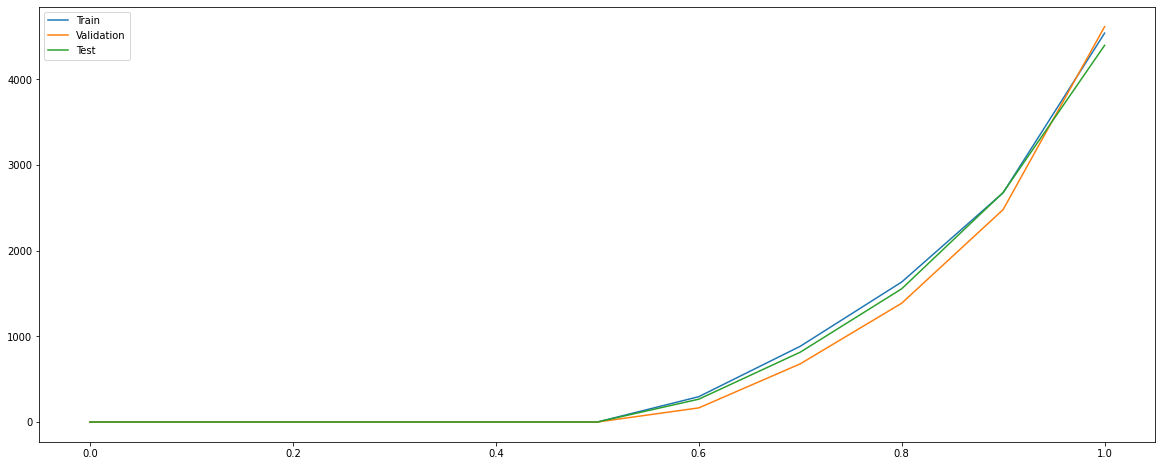

In [12]:
# Check data distribution of UPAC02

plot_quantiles(xgb_gt['upac08_allfeatures'])

In [13]:
# Calculate some metrics on the data (XGBoost all features)

xgb_u08_test_daily, xgb_u08_test_monthly, xgb_u08_test_averaged = calculate_dictionary_metrics(xgb_gt['upac08_allfeatures']['test'],
                                                                                               xgb_pred['upac08_allfeatures']['test'])

In [17]:
# Calculate metrics for TabNet (baseline)

tn_daily, tn_monthly, tn_averaged = calculate_dictionary_metrics(tn_gt['upac08_ghi+gti']['test'],
                                                                 tn_pred['upac08_ghi+gti']['test'])

In [14]:
# Show averages by day

xgb_u08_test_averaged

#tn_u08_test_averaged#.sort_values(by='RMSE (Daily Average)', ascending=True)

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 01            373.445014              400.415893   
Model 02            373.445014              400.415893   
Model 03            373.445014              400.415893   
Model 04            373.445014              400.415893   
Model 05            373.445014              400.415893   
Model 06            373.445014              400.415893   
Model 07            373.445014              400.415893   
Model 08            373.445014              400.415893   
Model 09            373.445014              400.415893   
Model 10            373.445014              400.415893   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 01                0.794341                  0.811066  
Model 02                0.794341                  0.811066  
Model 03                0.794341                  0.811066  
Model 04                0.794341                  0.811066  
Model 05                0.794341                  0.811066  
Model 06                0.794341                  0.811066  
Model 07                0.794341                  0.811066  
Model 08                0.794341                  0.811066  
Model 09                0.794341                  0.811066  
Model 10                0.794341                  0.811066

In [113]:
tnk_u08_test_averaged

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 01            332.010132              363.290395   
Model 02            339.944852              371.234485   
Model 03            613.460030              630.174307   
Model 04            405.586892              428.373808   
Model 05            341.967486              373.092434   
Model 06            343.162150              375.676873   
Model 07            337.909404              370.580814   
Model 08            347.135616              379.984292   
Model 09            331.788760              362.618395   
Model 10            391.652856              417.348234   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 01                0.797949                  0.815808  
Model 02                0.782770                  0.800234  
Model 03                0.814853                  0.782765  
Model 04                0.774388                  0.780312  
Model 05                0.777879                  0.798110  
Model 06                0.771454                  0.796347  
Model 07                0.790728                  0.808175  
Model 08                0.769415                  0.792505  
Model 09                0.801156                  0.819270  
Model 10                0.773089                  0.785353

In [108]:
xgb_u08_test_averaged

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 01            433.873424              462.516056   
Model 02            433.873424              462.516056   
Model 03            433.873424              462.516056   
Model 04            433.873424              462.516056   
Model 05            433.873424              462.516056   
Model 06            433.873424              462.516056   
Model 07            433.873424              462.516056   
Model 08            433.873424              462.516056   
Model 09            433.873424              462.516056   
Model 10            433.873424              462.516056   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 01                0.770444                  0.791812  
Model 02                0.770444                  0.791812  
Model 03                0.770444                  0.791812  
Model 04                0.770444                  0.791812  
Model 05                0.770444                  0.791812  
Model 06                0.770444                  0.791812  
Model 07                0.770444                  0.791812  
Model 08                0.770444                  0.791812  
Model 09                0.770444                  0.791812  
Model 10                0.770444                  0.791812

In [121]:
xgb1_u08_test_averaged

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 01            425.731192              447.728639   
Model 02            425.731192              447.728639   
Model 03            425.731192              447.728639   
Model 04            425.731192              447.728639   
Model 05            425.731192              447.728639   
Model 06            425.731192              447.728639   
Model 07            425.731192              447.728639   
Model 08            425.731192              447.728639   
Model 09            425.731192              447.728639   
Model 10            425.731192              447.728639   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 01                0.770661                  0.770337  
Model 02                0.770661                  0.770337  
Model 03                0.770661                  0.770337  
Model 04                0.770661                  0.770337  
Model 05                0.770661                  0.770337  
Model 06                0.770661                  0.770337  
Model 07                0.770661                  0.770337  
Model 08                0.770661                  0.770337  
Model 09                0.770661                  0.770337  
Model 10                0.770661                  0.770337

In [120]:
xgb4_u08_test_averaged

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 01            426.946145              457.003466   
Model 02            426.946145              457.003466   
Model 03            426.946145              457.003466   
Model 04            426.946145              457.003466   
Model 05            426.946145              457.003466   
Model 06            426.946145              457.003466   
Model 07            426.946145              457.003466   
Model 08            426.946145              457.003466   
Model 09            426.946145              457.003466   
Model 10            426.946145              457.003466   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 01                0.759682                  0.784271  
Model 02                0.759682                  0.784271  
Model 03                0.759682                  0.784271  
Model 04                0.759682                  0.784271  
Model 05                0.759682                  0.784271  
Model 06                0.759682                  0.784271  
Model 07                0.759682                  0.784271  
Model 08                0.759682                  0.784271  
Model 09                0.759682                  0.784271  
Model 10                0.759682                  0.784271

In [87]:
# Aux Function to plot Y and Yhat throught a month

import matplotlib.pyplot as plt
import IPython

def plot_months(y, yhat, month, suppress_warning=False, figsize=(80, 240)):
    # Get days in month to know how many plots to draw
    y_firstIndex = y.loc[y.index.month == month].index[0]
    days_in_month = y_firstIndex.days_in_month
    
    if isinstance(yhat, pd.DataFrame):
        fig, axs = plt.subplots(ncols=1, nrows=days_in_month, figsize=figsize)

        for day in np.arange(1, days_in_month+1):
            current_date = '{}-{}-{}'.format(y_firstIndex.year, y_firstIndex.month, day)
            try:
                axs[day-1].plot(y['PV'][current_date])
                axs[day-1].plot(yhat['PV'][current_date])
                #axs[day].plot(original_ghi['Ghi'][current_date])
                #axs[day].plot(original_cloud['CloudOpacity'][current_date])
                #axs[day].plot(original_temp['AirTemp'][current_date])
                

                axs[day-1].set_title('{}'.format(current_date))
                axs[day-1].legend(['Original PV', 'Predicted PV'])#, 'Ghi', 'CloudOpacity', 'AirTemp'])
            except:
                if suppress_warning:
                    pass
                else:
                    print('{} not present'.format(current_date))

        #plt.hlines(1000, 0, 96, linestyles='--')
        plt.tight_layout()
        
    elif isinstance(yhat, dict):
        fig, axs = plt.subplots(ncols=len(yhat), nrows=days_in_month, figsize=figsize)
        
        model_list = list(yhat.keys())
        for model_ix in np.arange(len(model_list)):
            for day in np.arange(1, days_in_month+1):
                current_date = '{}-{}-{}'.format(y_firstIndex.year, y_firstIndex.month, day)
                try:
                    axs[day-1, model_ix].plot(y['PV'][current_date])
                    axs[day-1, model_ix].plot(yhat[model_list[model_ix]]['PV'][current_date])
                    #axs[day, model_ix].plot(original_ghi['Ghi'][current_date])
                    #axs[day, model_ix].plot(original_cloud['CloudOpacity'][current_date])
                    #axs[day, model_ix].plot(original_temp['AirTemp'][current_date])

                    axs[day-1, model_ix].set_title('{} - {}'.format(model_list[model_ix], current_date))
                    axs[day-1, model_ix].legend(['Original PV', 'Predicted PV'])#, 'Ghi', 'CloudOpacity', 'AirTemp'])
                    #axs[day, model_ix].autoscale(tight=True)
                except:
                    if suppress_warning:
                        pass
                    else:
                        print('{} not present'.format(current_date))
                    
                    
        plt.autoscale(tight=True)

In [88]:
# Plot the data

plot_months(y=tn_gt['upac08']['test'], yhat=tn_pred['upac08']['test'], month=8, suppress_warning=True)

In [23]:
# Display the RMSE and CEP CX for the plot above

pd.DataFrame(xgb_u08_test_daily['Model 08']['PV'][['rmse', 'cep_cx']]['2020-08'], 
             index=xgb_gt['upac08']['test'].index).describe()

C:\Users\FEEL\AppData\Local\Temp/ipykernel_14420/3056576830.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pd.DataFrame(xgb_u08_test_daily['Model 08']['PV'][['rmse', 'cep_cx']]['2020-08'],


rmse     cep_cx
count   30.000000  30.000000
mean   383.402125   0.842875
std    177.015221   0.117415
min     95.468581   0.559590
25%    246.192879   0.761129
50%    384.244457   0.873913
75%    505.517211   0.941573
max    673.590944   0.986781

In [89]:
# Select the best models for the UPAC

def get_bestmodel(averaged_metrics):
    # Opted to go by the daily averages
    return averaged_metrics.loc[
        averaged_metrics['RMSE (Daily Average)'] == averaged_metrics['RMSE (Daily Average)'].min()].head(1)

get_bestmodel(tn_u08_test_averaged)

RMSE (Daily Average)  RMSE (Monthly Average)  \
Model 09            338.386564              367.805444   

          CEP CX (Daily Average)  CEP CX (Monthly Average)  
Model 09                0.806967                  0.827495

In [54]:
# Aux Function for gathering best results for each algorithm

def get_bestalgo(dictionary):
    # Create an empty dataframe for appending results
    empty_df = pd.DataFrame({})
    
    # Go through each algorithm
    for key in dictionary.keys():
        temp_bestmodel = get_bestmodel(dictionary[key])
        temp_bestmodel.index = ['{} - {}'.format(key, temp_bestmodel.index[0])]
        empty_df = empty_df.append(temp_bestmodel)
        
    return empty_df

In [253]:
# Check best algorithm

best_algo = get_bestalgo({#'NN': nn_u08_test_averaged,
                          'XGBoost': xgb_u08_test_averaged,
                          'XGBoost Top 1': xgb1_u08_test_averaged,
                          'XGBoost Corr': xgbcorr_u08_test_averaged,
                          'XGBoost Variance': xgbvar_u08_test_averaged,
                          #'XGBoost Top 4': xgb4_u08_test_averaged,
                          'Tabnet': tn_u08_test_averaged,
                          'TabNet Top 4': tnk_u08_test_averaged,
                          'TabNet Top 1': tn1_u08_test_averaged,
                          'TabNet Corr': tncorr_u08_test_averaged,
                          'TabNet Variance': tnvar_u08_test_averaged})

best_algo

RMSE (Daily Average)  RMSE (Monthly Average)  \
XGBoost - Model 01                     433.873424              462.516056   
XGBoost Top 1 - Model 01               425.731192              447.728639   
XGBoost Corr - Model 01                509.597540              530.590385   
XGBoost Variance - Model 01           1023.839773             1078.152599   
Tabnet - Model 09                      338.386564              367.805444   
TabNet Top 4 - Model 09                331.788760              362.618395   
TabNet Top 1 - Model 09                398.423794              421.021662   
TabNet Corr - Model 02                 398.624492              421.546984   
TabNet Variance - Model 08             988.824651             1014.125541   

                             CEP CX (Daily Average)  CEP CX (Monthly Average)  
XGBoost - Model 01                         0.770444                  0.791812  
XGBoost Top 1 - Model 01                   0.770661                  0.770337  
XGBoost Corr - Model 01                    0.744151                  0.750196  
XGBoost Variance - Model 01                0.523393                  0.510166  
Tabnet - Model 09                          0.806967                  0.827495  
TabNet Top 4 - Model 09                    0.801156                  0.819270  
TabNet Top 1 - Model 09                    0.793248                  0.792168  
TabNet Corr - Model 02                     0.795748                  0.797538  
TabNet Variance - Model 08                 0.525165                  0.468244

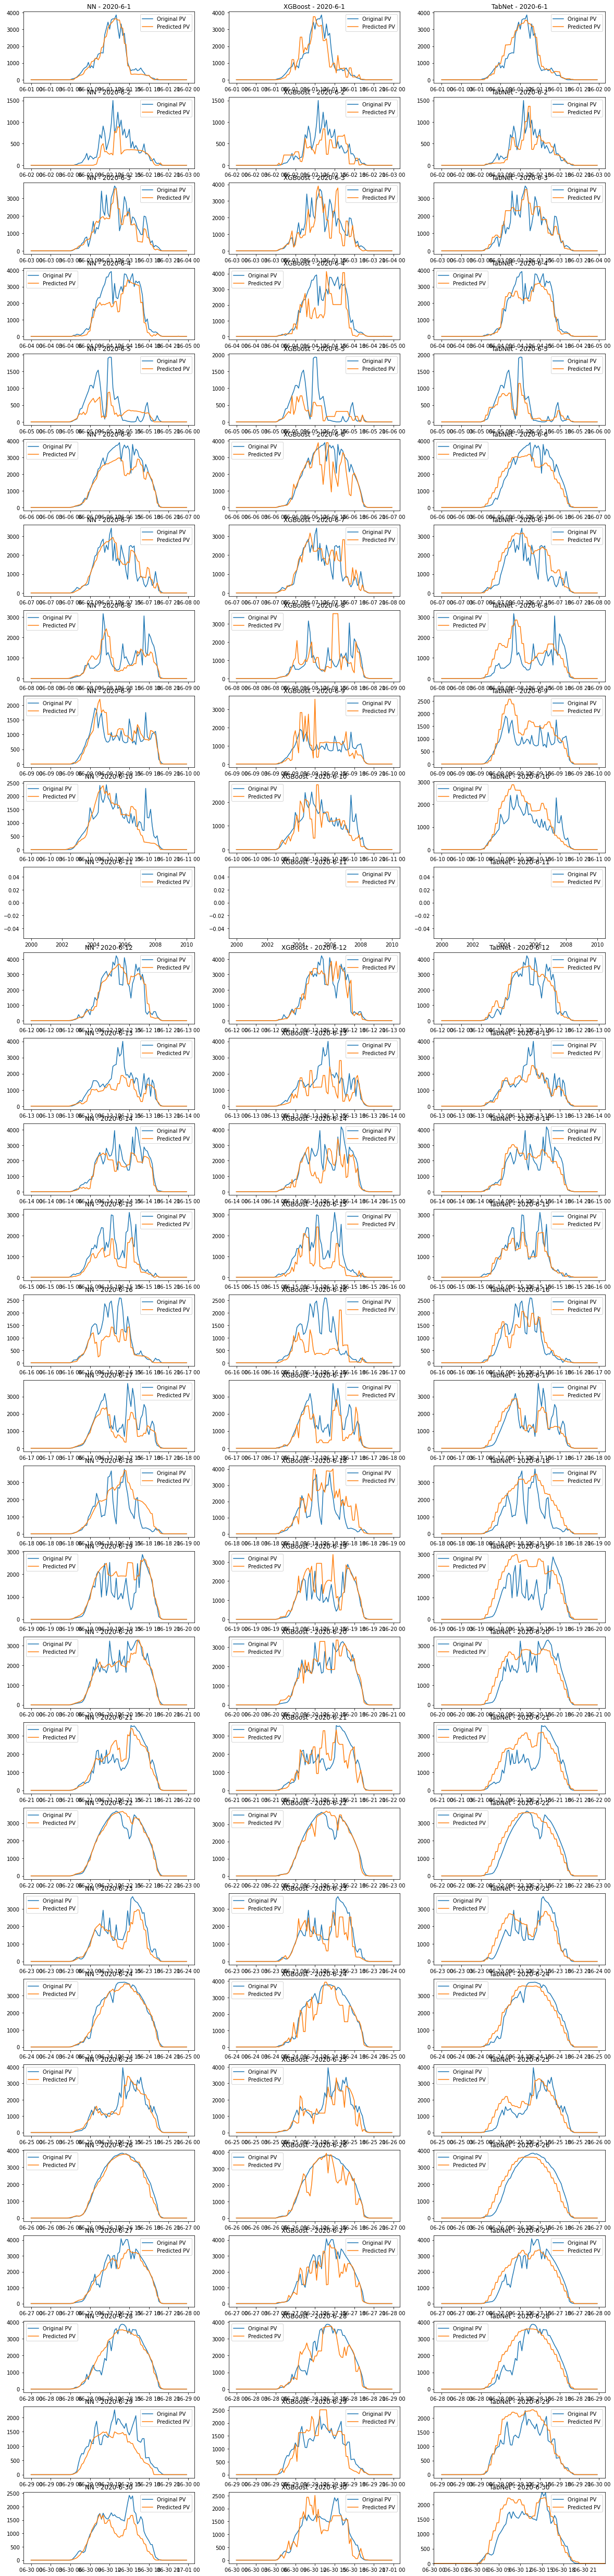

In [28]:
# Plot of days in a month

plot_months(y=nn_gt['upac08']['test'], 
            yhat={'NN': nn_pred['upac08']['test']['Model 08'],
                  'XGBoost': xgb_pred['upac08']['test']['Model 01'],
                  'TabNet': tn_pred['upac08']['test']['Model 02']},
            month=6, suppress_warning=True,
            figsize=(20, 90))

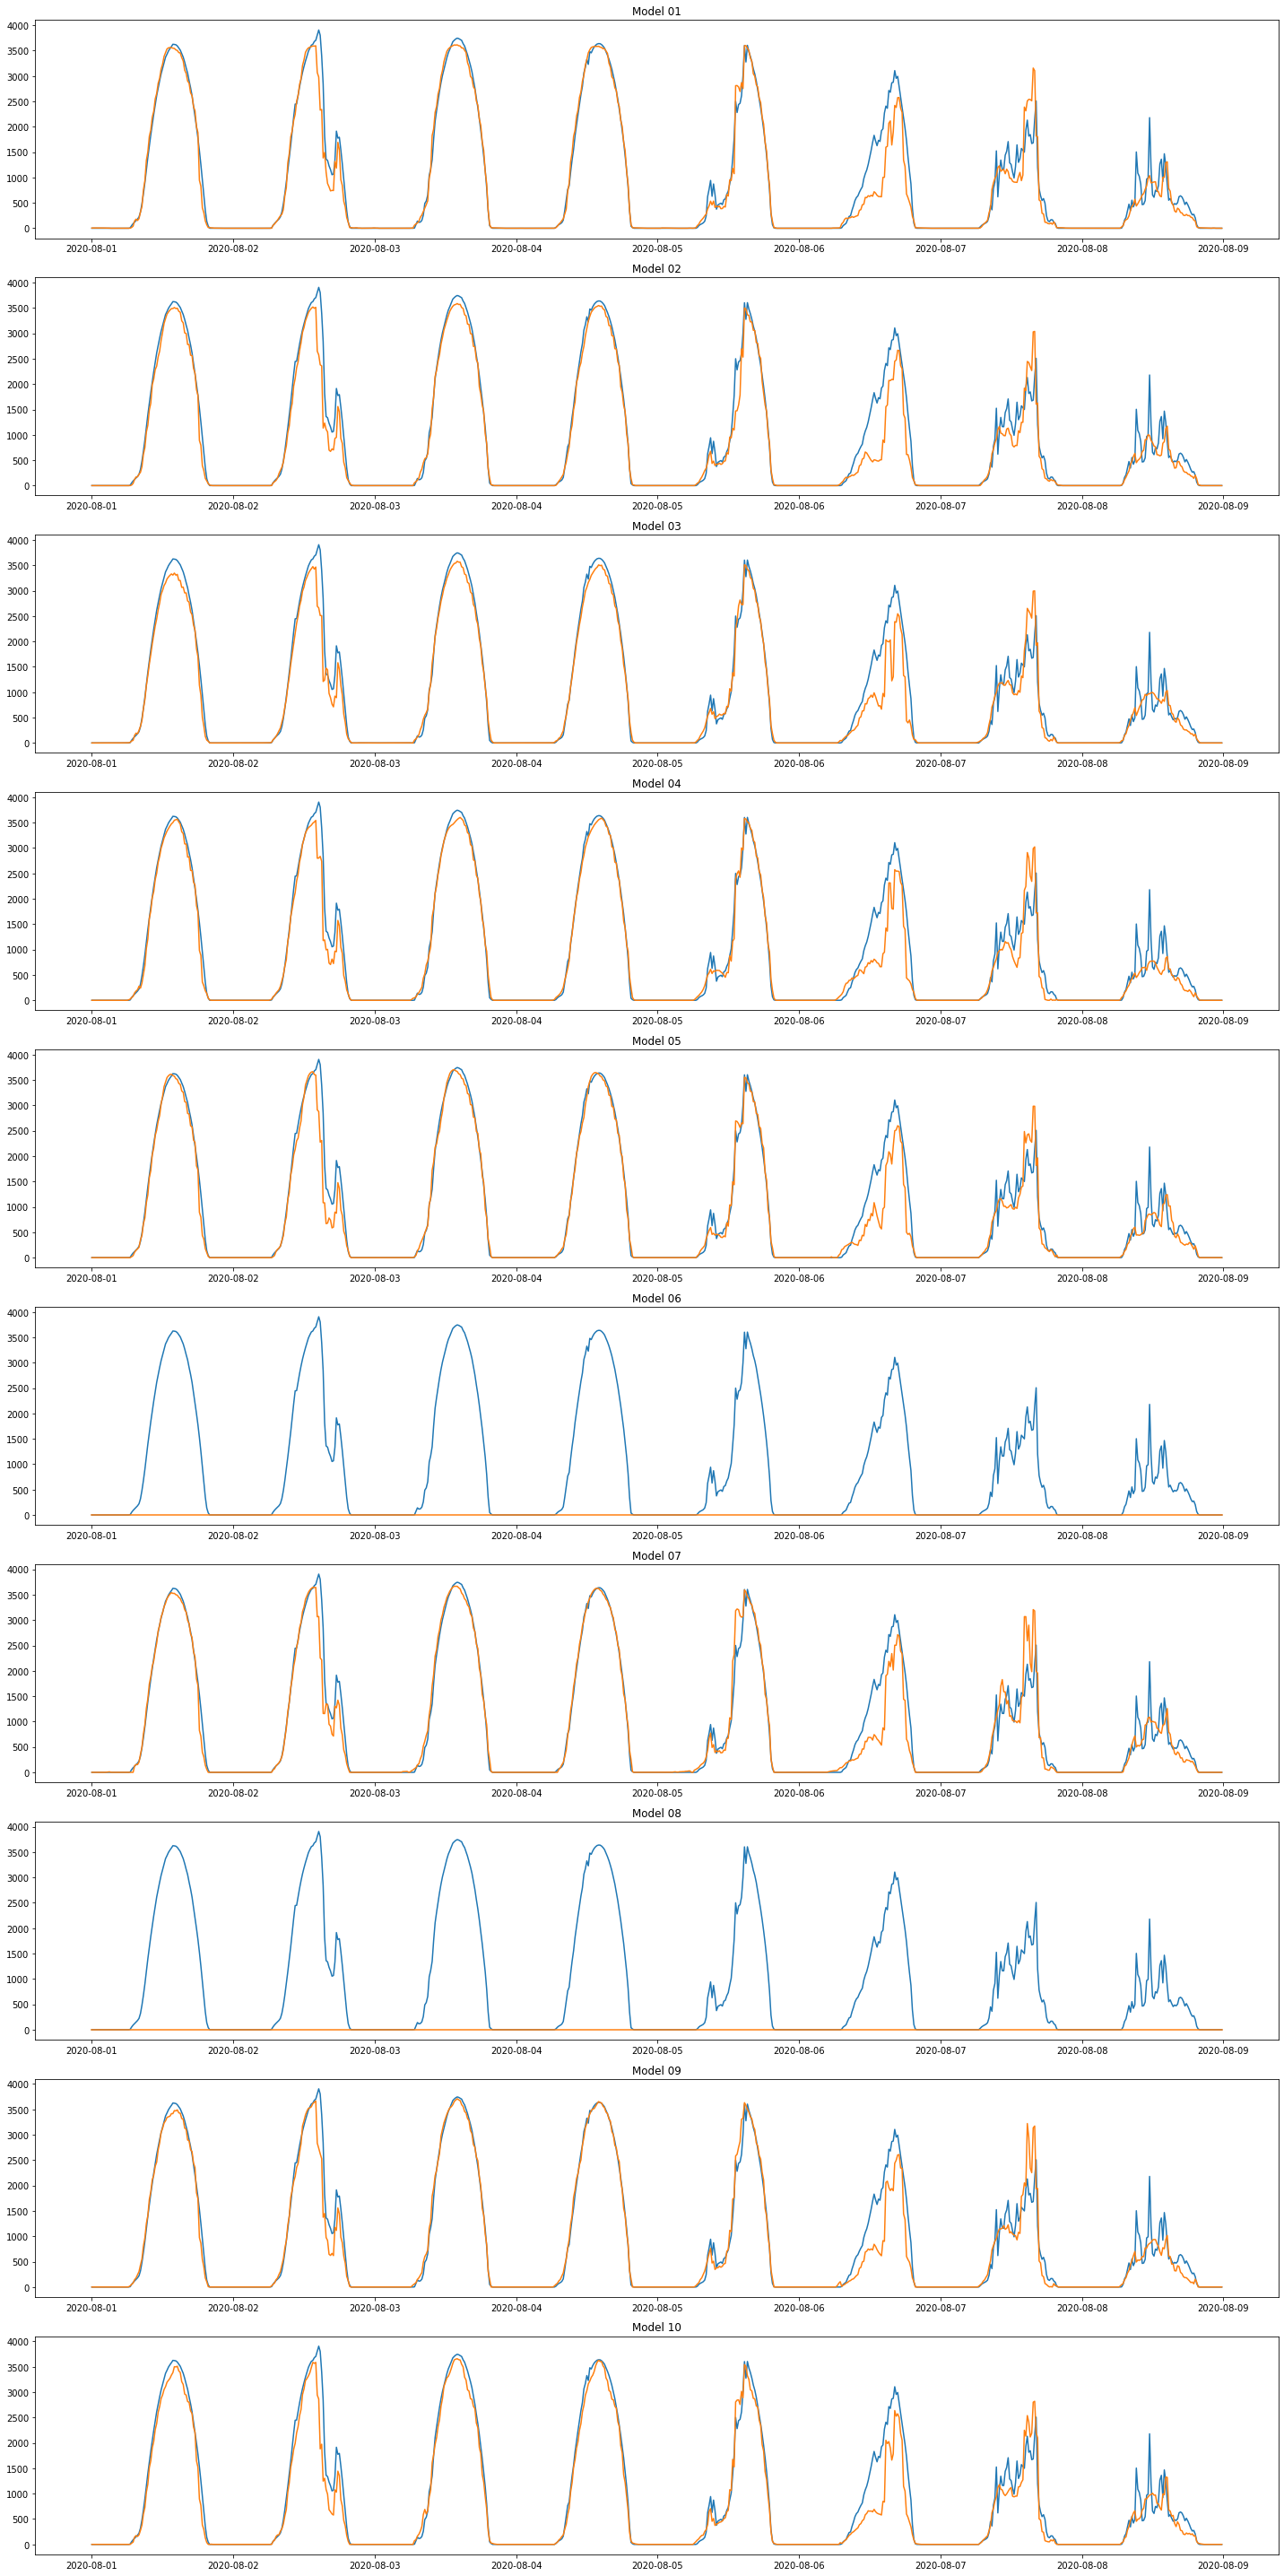

In [90]:
# Model day week plot

fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 40))

for key in np.arange(len(tn_pred['upac08']['test'])):
    current_key = list(tn_pred['upac08']['test'].keys())[key]
    
    axs[key].plot(tn_gt['upac08']['test']['2020-08-01':'2020-08-08'])
    axs[key].plot(tn_pred['upac08']['test'][current_key]['2020-08-01':'2020-08-08'])
    
    axs[key].set_title(current_key)
    
plt.tight_layout()

In [206]:
# Add season information to dataframes

def extract_season(df):
    
    date = df.index.month*100 + df.index.day
    df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                           labels=['winter','spring','summer','autumn','winter '])
                    #.str.strip()
                   )
    df['season'] = df['season'].str.replace(' ', '')
    df['season'] = df['season'].astype('category')
    
    df['season_int'] = df['season'].cat.codes
    
    return

season_gt = xgb_gt['upac08']['test'].copy(deep=True)
extract_season(season_gt)

xgb_all = xgb_pred['upac08']['test']['Model 01'].copy(deep=True)
extract_season(xgb_all)

xgb_top1 = xgb_pred['upac08_top1']['test']['Model 01'].copy(deep=True)
extract_season(xgb_top1)

tn_all = tn_pred['upac08']['test']['Model 09'].copy(deep=True)
extract_season(tn_all)

tn_top4 = tn_pred['upac08_topk']['test']['Model 09'].copy(deep=True)
extract_season(tn_top4)

tn_top1 = tn_pred['upac08_top1']['test']['Model 09'].copy(deep=True)
extract_season(tn_top1)

In [214]:
# Metric Calculation for each model

def model_season_metrics(gt, pred):
    
    season_daily_metrics = {}
    season_monthly_metrics = {}
    season_averaged_metrics = {}
    
    for season in pred['season'].unique():
        new_gt = gt.loc[gt['season'] == season].drop(['season', 'season_int'], axis=1)
        new_pred = pred.loc[pred['season'] == season].drop(['season', 'season_int'], axis=1)
        
        metrics_ee = MetricsEE()
        ee_daily_metrics = metrics_ee.check_metrics(new_gt, new_pred,
                                                    metric_list=['rmse'],
                                                    interval='Day')
        
        temp_df = pd.DataFrame({'RMSE (Daily Average)': ee_daily_metrics['PV']['rmse'].describe().loc['mean'],
                                'RMSE (Daily Std)' : ee_daily_metrics['PV']['rmse'].describe().loc['std']},
                               index=[0])
        
        season_daily_metrics[season] = ee_daily_metrics
        season_averaged_metrics[season] = temp_df
        
    metrics = {}
    metrics['Daily'] = season_daily_metrics
    metrics['Averaged'] = season_averaged_metrics
    
    return metrics

xgb_all_metrics = model_season_metrics(season_gt, xgb_all)
xgb_top1_metrics = model_season_metrics(season_gt, xgb_top1)

tn_all_metrics = model_season_metrics(season_gt, tn_all)
tn_top4_metrics = model_season_metrics(season_gt, tn_top4)

tn_top1_metrics = model_season_metrics(season_gt, tn_top1)

In [208]:
# Add season information for feature selection models

xgb_corr = xgb_pred['upac08_spearman_ghidayx']['test']['Model 01'].copy(deep=True)
extract_season(xgb_corr)

xgb_var = xgb_pred['upac08_variance']['test']['Model 01'].copy(deep=True)
extract_season(xgb_var)

tn_corr = tn_pred['upac08_spearman_ghidayx']['test']['Model 02'].copy(deep=True)
extract_season(tn_corr)

tn_var = tn_pred['upac08_variance']['test']['Model 08'].copy(deep=True)
extract_season(tn_var)

In [255]:
# Model Metrics for feature selection models

xgb_corr_metrics = model_season_metrics(season_gt, xgb_corr)

xgb_var_metrics = model_season_metrics(season_gt, xgb_var)

tn_corr_metrics = model_season_metrics(season_gt, tn_corr)

tn_var_metrics = model_season_metrics(season_gt, tn_var)

In [257]:
# Put everything on a unified table

metrics_table = {'Overall': best_algo['RMSE (Daily Average)'].values,
                 'Spring': [xgb_all_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0]],
                 'Summer': [xgb_all_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0]],
                 'Autumn': [xgb_all_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0]],
                 'Winter': [xgb_all_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0]]}

metrics_table = pd.DataFrame(metrics_table, index=['XGBoost', 'XGBoost Top 1', 'XGBoost Corr', 'XGBoost Variance',
                                                   'TabNet', 'TabNet Top 4', 'TabNet Top 1', 'TabNet Corr', 'TabNet Variance'])
metrics_table

Overall       Spring       Summer      Autumn  \
XGBoost            433.873424   482.358689   416.215553  423.377781   
XGBoost Top 1      425.731192   432.499751   416.211796  423.594992   
XGBoost Corr       509.597540   528.390224   523.265923  496.974653   
XGBoost Variance  1023.839773  1168.640980   931.213302  890.511533   
TabNet             338.386564   358.764108   325.473623  347.393767   
TabNet Top 4       331.788760   354.781688   283.521094  340.874931   
TabNet Top 1       398.423794   407.603881   388.572130  395.937411   
TabNet Corr        398.624492   410.160494   394.680189  392.924077   
TabNet Variance    988.824651  1068.513826  1140.747823  843.815565   

                       Winter  
XGBoost            415.103459  
XGBoost Top 1      430.899026  
XGBoost Corr       489.951270  
XGBoost Variance  1107.854524  
TabNet             322.926408  
TabNet Top 4       349.465443  
TabNet Top 1       401.938010  
TabNet Corr        397.031578  
TabNet Variance    899.992008

In [258]:
# Metric differences - XGBoost

xgb_changes = metrics_table.copy(deep=True)
xgb_changes = xgb_changes.iloc[:4]

xgb_changes = xgb_changes / xgb_changes.iloc[0]
xgb_changes[1:] -= 1
xgb_changes[1:] *= -100

xgb_changes

Overall      Spring      Summer      Autumn      Winter
XGBoost             1.000000    1.000000    1.000000    1.000000    1.000000
XGBoost Top 1       1.876638   10.336486    0.000903   -0.051304   -3.805212
XGBoost Corr      -17.453043   -9.543009  -25.719935  -17.383263  -18.031122
XGBoost Variance -135.976604 -142.276341 -123.733422 -110.334971 -166.886363

In [259]:
# Metric differences - TabNet

tn_changes = metrics_table.copy(deep=True)
tn_changes = tn_changes.iloc[4:]

tn_changes = tn_changes / tn_changes.iloc[0]
tn_changes[1:] -= 1
tn_changes[1:] *= -100

tn_changes

Overall      Spring      Summer      Autumn      Winter
TabNet             1.000000    1.000000    1.000000    1.000000    1.000000
TabNet Top 4       1.949783    1.110038   12.889686    1.876498   -8.218292
TabNet Top 1     -17.742203  -13.613339  -19.386673  -13.973666  -24.467371
TabNet Corr      -17.801513  -14.325956  -21.263341  -13.106254  -22.948006
TabNet Variance -192.217468 -197.831863 -250.488563 -142.898879 -178.698795

In [175]:
# Other feature selection methods

xgbcorr_u08_test_daily, xgbcorr_u08_test_monthly, xgbcorr_u08_test_averaged = calculate_dictionary_metrics(xgb_gt['upac08_spearman_ghidayx']['test'],
                                                                                                           xgb_pred['upac08_spearman_ghidayx']['test'])

xgbvar_u08_test_daily, xgbvar_u08_test_monthly, xgbvar_u08_test_averaged = calculate_dictionary_metrics(xgb_gt['upac08_variance']['test'],
                                                                                                        xgb_pred['upac08_variance']['test'])

tncorr_u08_test_daily, tncorr_u08_test_monthly, tncorr_u08_test_averaged = calculate_dictionary_metrics(tn_gt['upac08_spearman_ghidayx']['test'],
                                                                                                        tn_pred['upac08_spearman_ghidayx']['test'])

tnvar_u08_test_daily, tnvar_u08_test_monthly, tnvar_u08_test_averaged = calculate_dictionary_metrics(tn_gt['upac08_variance']['test'],
                                                                                                     tn_pred['upac08_variance']['test'])

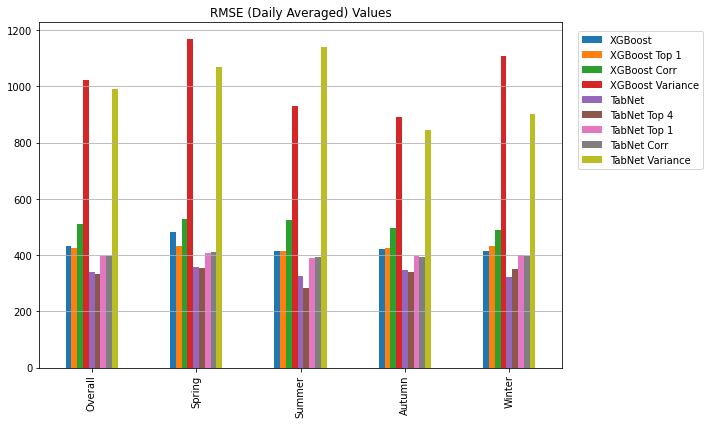

In [273]:
metrics_table.transpose().plot(kind='bar', figsize=(8, 6))

plt.title('RMSE (Daily Averaged) Values')

plt.tight_layout()

plt.legend(bbox_to_anchor=(1.28, 0.99))

plt.grid(axis='y')

plt.show()